Question 1

In [114]:
import numpy as np

def alpha_stable_sample_MC(n, alpha, beta=1, gamma=1, delta=0):
    # Initialize samples array with zeros
    sample = np.zeros(n)
    
    # Constants that do not depend on the sample index and thus can be computed once
    if alpha != 1:
        S_alpha_beta = (1 + beta ** 2 * np.tan(np.pi * alpha / 2) ** 2) ** (1 / (2 * alpha))
        B_alpha_beta = (1 / alpha) * np.arctan(beta * np.tan(np.pi * alpha / 2))

    for i in range(n):
        U = np.random.uniform(-np.pi/2, np.pi/2)
        W = -np.log(1 - np.random.uniform(0,1))
        
        # Handle the case alpha = 1 separately
        if alpha != 1:
            part1 = np.sin(alpha * (U + B_alpha_beta)) / (np.cos(U) ** (1 / alpha))
            part2 = (np.cos(U - alpha * (U + B_alpha_beta)) / W) ** ((1 - alpha) / alpha)
            sample[i] = S_alpha_beta * part1 * part2
        else:
            sample[i] = (2 / np.pi) * ((np.pi / 2 + beta * U) * np.tan(U) - beta * np.log((np.pi / 2 * W * np.cos(U))/(np.pi+beta*U)))

    # Apply scaling and location shifting
    sample = gamma * sample + delta
    return sample


In [118]:
# Generate a sample
alpha = 2
n=100000
y_mc = alpha_stable_sample(n,alpha)


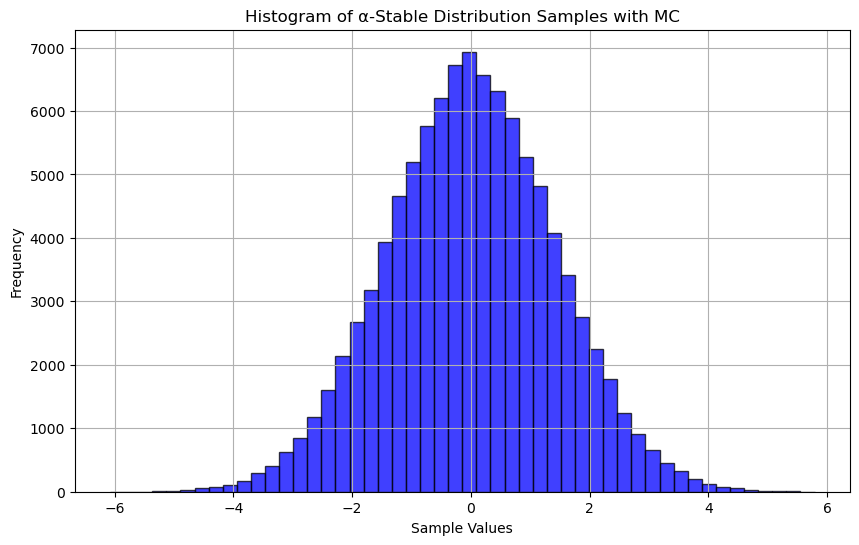

In [119]:
import matplotlib.pyplot as plt
# Plotting
plt.figure(figsize=(10, 6))
plt.hist(y_mc, bins=50, alpha=0.75, color='blue', edgecolor='black')
plt.title('Histogram of α-Stable Distribution Samples with MC')
plt.xlabel('Sample Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [120]:
def generate_multivariate_alpha_stable(n,d, k, alpha, beta=1, gamma=1, delta=0):
    sample = np.zeros((n,d))

    # Initialize the resulting vector
    Y = np.zeros(d)

    
    # Generate random weights and direction vectors
    weights = np.random.rand(k)  # Random weights
    directions = np.random.randn(k, d)  # Random direction vectors in d dimensions
    for i in range(n):
        # Generate each Z_j 
        Z = alpha_stable_sample(k,alpha)
        #apply the transformation
        for j in range(k):        
            # If alpha is not 1, use the transformation for alpha not equal to 1
            if alpha != 1:
                  contribution = (weights[j] ** (1/alpha)) * Z[j] * directions[j]
            else:
                 # If alpha is 1, include the logarithmic adjustment in the transformation
                  contribution = weights[j] * (Z[j] + (2 / np.pi) * np.log(weights[j])) * directions[j]
        
           # Add the contribution to the final vector Y
            Y += contribution
       
           # Adjust Y by adding a location vector mu0 (set to zero here for simplicity)
        mu0 = np.zeros(d)
        Y += mu0
        sample[i]=Y
    
    return sample

In [131]:
# Example of generating one sample
alpha=2
sample_d = generate_multivariate_alpha_stable(n=100000,d=3, k=100,alpha=2)

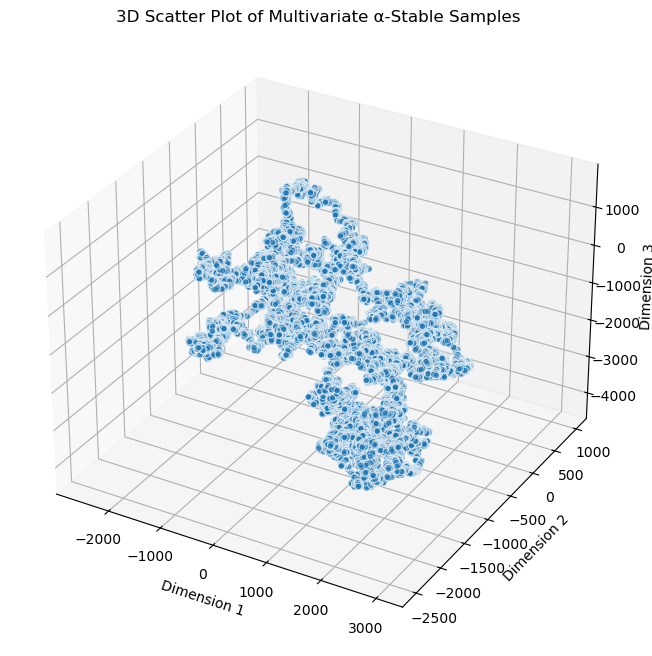

In [132]:
x = sample_d[:, 0]  # x-coordinates
y = sample_d[:, 1]  # y-coordinates
z = sample_d[:, 2]  # z-coordinates from the third column

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))  # Create a figure
ax = fig.add_subplot(111, projection='3d')  # Add a 3D subplot

# Plot data
ax.scatter(x, y, z, alpha=0.6, edgecolor='w', linewidth=0.5)  # Scatter plot

# Set labels and title
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.set_title('3D Scatter Plot of Multivariate α-Stable Samples')

plt.show()  # Display the plot

Question 2 : Integrate Stratified Sampling in α-Stable Distribution Generation

In [133]:
def stratified_sampling(a, b, N, K, method='uniform'):
    """
    Generate stratified samples over a specified interval [a, b].
    
    Args:
        a (float): Lower bound of the interval.
        b (float): Upper bound of the interval.
        N (int): Total number of samples to generate.
        K (int): Number of strata.
        method (str): Method of sampling within strata ('uniform', 'single_point', 'middle').

    """
    samples = []
    interval_length = (b - a) / K

    for k in range(K):
        # Calculate the bounds of the k-th interval
        low = a + k * interval_length
        high = low + interval_length

        if method == 'uniform':
            # Generate N/K samples within this interval
            samples.extend(np.random.uniform(low, high, size=N//K))
        elif method == 'single_point':
            # Generate one random sample in each interval
            if N == K:  # Ensure N equals K for this method to work correctly
                samples.append(np.random.uniform(low, high))
            else:
                raise ValueError("N must be equal to K for 'single_point' sampling method.")
        elif method == 'middle':
            # Use the midpoint of each interval
            if N == K:  # Ensure N equals K for this method to work correctly
                midpoint = (low + high) / 2
                samples.append(midpoint)
            else:
                raise ValueError("N must be equal to K for 'middle' sampling method.")
        else:
            raise ValueError("Unsupported method. Choose 'uniform', 'single_point', 'middle'.")

    return np.array(samples)

In [134]:
def alpha_stable_sample_QMC(n, alpha, beta=1, gamma=1, delta=0):
    # Initialize samples array with numpy for better performance with vectorized operations
    sample = np.zeros(n)
    
    # Constants that do not depend on the sample index and thus can be computed once
    if alpha != 1:
        S_alpha_beta = (1 + beta ** 2 * np.tan(np.pi * alpha / 2) ** 2) ** (1 / (2 * alpha))
        B_alpha_beta = (1 / alpha) * np.arctan(beta * np.tan(np.pi * alpha / 2))

    
    U = stratified_sampling(-np.pi/2, np.pi/2, n, K=100, method='uniform')
    W = -np.log(1 - stratified_sampling(0, 1, n, K=100, method='uniform'))
        
    # Handle the case alpha = 1 separately
    if alpha != 1:
        part1 = np.sin(alpha * (U + B_alpha_beta)) / (np.cos(U) ** (1 / alpha))
        part2 = (np.cos(U - alpha * (U + B_alpha_beta)) / W) ** ((1 - alpha) / alpha)
        sample = S_alpha_beta * part1 * part2
    else:
        sample = (2 / np.pi) * ((np.pi / 2 + beta * U) * np.tan(U) - beta * np.log((np.pi / 2 * W * np.cos(U))/(np.pi+beta*U)))

    # Apply scaling and location shifting
    sample = gamma * sample + delta
    return sample

In [135]:
# Generate a sample
alpha = 2
n=100000
y_qmc = alpha_stable_sample_QMC(n,alpha)

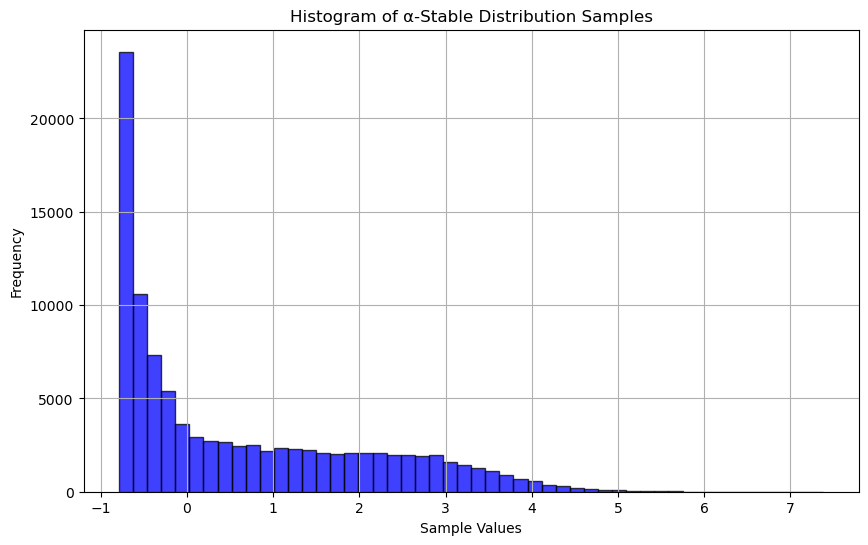

In [136]:
import matplotlib.pyplot as plt
# Plotting
plt.figure(figsize=(10, 6))
plt.hist(y_qmc, bins=50, alpha=0.75, color='blue', edgecolor='black')
plt.title('Histogram of α-Stable Distribution Samples')
plt.xlabel('Sample Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [137]:
def alpha_stable_sample_RQMC(n, alpha, beta=1, gamma=1, delta=0):
    # Initialize samples array with numpy for better performance with vectorized operations
    sample = np.zeros(n)
    
    # Constants that do not depend on the sample index and thus can be computed once
    if alpha != 1:
        S_alpha_beta = (1 + beta ** 2 * np.tan(np.pi * alpha / 2) ** 2) ** (1 / (2 * alpha))
        B_alpha_beta = (1 / alpha) * np.arctan(beta * np.tan(np.pi * alpha / 2))

    # Random shifts
    random_shift_U = np.random.uniform(-np.pi/2, np.pi/2)
    random_shift_W = np.random.uniform(0, 1)
    
    # Generate stratified U and W with random shift
    U = (stratified_sampling(-np.pi/2, np.pi/2, n, K=100, method='uniform') + random_shift_U) % (np.pi) - np.pi/2
    W = -np.log(1 - (stratified_sampling(0, 1, n, K=100, method='uniform') + random_shift_W) % 1)

    
    # Handle the case alpha = 1 separately
    if alpha != 1:
        part1 = np.sin(alpha * (U + B_alpha_beta)) / (np.cos(U) ** (1 / alpha))
        part2 = (np.cos(U - alpha * (U + B_alpha_beta)) / W) ** ((1 - alpha) / alpha)
        sample = S_alpha_beta * part1 * part2
    else:
        sample = (2 / np.pi) * ((np.pi / 2 + beta * U) * np.tan(U) - beta * np.log((np.pi / 2 * W * np.cos(U))/(np.pi+beta*U)))

    # Apply scaling and location shifting
    sample = gamma * sample + delta
    return sample

In [138]:
# Generate a sample
alpha = 1.5
n=100000
y_rqmc = alpha_stable_sample_RQMC(n,alpha)

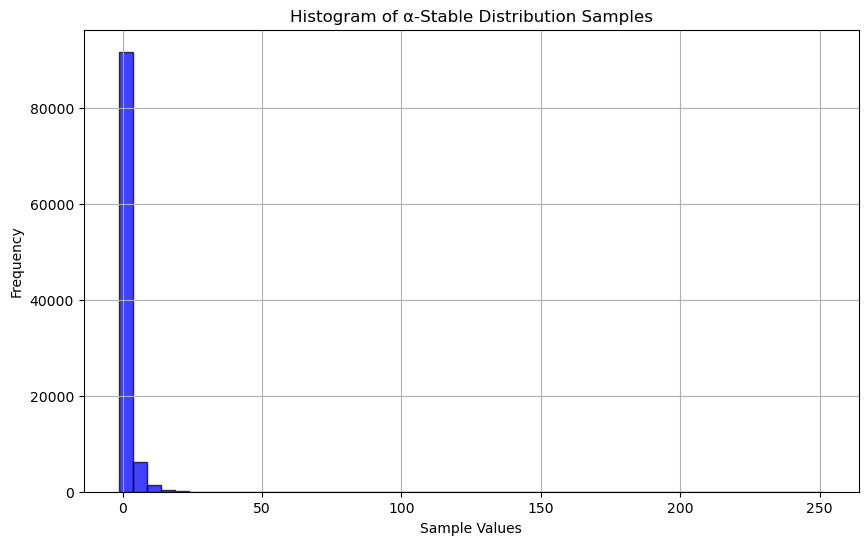

In [139]:
import matplotlib.pyplot as plt
# Plotting
plt.figure(figsize=(10, 6))
plt.hist(y_rqmc, bins=50, alpha=0.75, color='blue', edgecolor='black')
plt.title('Histogram of α-Stable Distribution Samples')
plt.xlabel('Sample Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [140]:
# Apply function and calculate expectations
expect_rqmc = np.mean(np.exp(-y_rqmc))
expect_mc = np.mean(np.exp(-y_mc))

# Display results
print("RQMC Expected Value: ", expect_rqmc)
print("MC Expected Value: ", expect_mc)

RQMC Expected Value:  2.038585518460525
MC Expected Value:  2.734771121790252
